In [96]:
import os
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy as sp
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import sem
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
import seaborn as sns
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [59]:
master = pd.read_csv('Master_file')

In [60]:
len(master.columns.tolist())

420

In [61]:
# Deleting columns with more than 30% null values

for col in master.columns:
  if master[col].isna().sum() >= 0.3 * len(master):
    del master[col]
cols = master.columns.tolist()
len(cols)

222

In [62]:
# Dropping numerical features with < 3  unique values
for col in master.columns:
  if master[col].nunique() < 3 and master[col].dtype == 'float64':
    print(f"{col} {master[col].dtype}: {master[col].unique()}\n\n")
    del master[col]
cols = master.columns.tolist()
len(cols)

volume_outer-PTV_BODY float64: [0.         1.56789567]


volume-ratio_outer-PTV_BODY float64: [0.00000000e+00 7.16429681e-08]


total-dose_prescribed_course float64: [70. nan]


dose_prescribed_fx float64: [ 2. nan]


PEG float64: [ 1.  0. nan]




217

In [63]:
# List of columns having categorical data
obj_df = master.select_dtypes(include=['object']).copy()
obj_df.head()

,replanned_or_not,sex,cancer_category,diagnosis_id,stage_summary,T,N,M,chemo
0,R,Male,Oropharyngeal cancer,C01,IVA,T4,N2c,M0,Chemo
1,R,Female,Oropharyngeal cancer,C09.9,IVA,T4,N2c,M0,Chemo
2,R,Male,Nasopharyngeal Cancer,C11.9,III,T1,N2,M0,Chemo
3,R,Male,Oropharyngeal cancer,C01,X,T2,N2b,M0,Chemo
4,R,Male,Oropharyngeal cancer,C01,X,T2,N3,MX,Chemo


In [64]:
# List of columns having numerical data
num_df = master.select_dtypes(include=['int64','float64']).copy()
num_df.head()

,patient_num,BODY,Body-1,xmin-slope_Body-1,xmin-slope_Body-2,xmin-slope_Body-3,xmin-slope_Body-4,xmin-slope_Body-5,xmin-slope_Body-6,xmin-slope_Body-7,...,volume-ratio-slope_outer-PTV_Body-22,volume-ratio-slope_outer-PTV_Body-23,volume-ratio-slope_outer-PTV_Body-24,volume-ratio-slope_outer-PTV_Body-25,volume-ratio-slope_outer-PTV_Body-26,age_start,cancer_category_id,num_chemo,first_weight_kg,total_weight-loss_kg
0,19,21.484754,20.805747,-5.599176,-5.599176,-5.599176,-5.599176,-5.599176,-0.660966,-0.660966,...,0.000282,0.000282,0.000282,0.000282,0.000282,56.5421,2.0,3.0,99.3,12.7895
1,35,18.636867,21.230902,-3.322000,-3.322000,-0.553786,-0.553786,-0.553786,-0.841991,-0.841991,...,0.000009,0.000014,0.000014,0.000014,0.000014,54.1246,2.0,3.0,64.7,10.6646
2,115,21.957419,21.883293,-1.557421,-1.557421,-1.557421,-0.319167,-0.319167,-0.202706,-0.202706,...,0.000011,0.000011,0.000007,0.000007,0.000004,49.8700,4.0,3.0,69.5,12.5180
3,272,22.138647,20.795968,-6.803470,-6.803470,-6.803470,-6.803470,-6.803470,-0.905675,-0.905675,...,0.000627,0.000568,0.000568,0.000568,0.000568,68.2574,2.0,3.0,98.7,10.5370
4,447,19.842300,21.966858,-4.473957,-4.473957,-4.473957,-0.970603,-1.415517,-1.415517,-1.415517,...,0.000405,0.000405,0.000405,0.000405,0.000405,65.0157,2.0,3.0,72.0,4.0278


In [65]:
# Filled Nan with mode
print(master['cancer_category_id'].value_counts())
master['cancer_category_id'].fillna(master['cancer_category_id'].mode()[0],inplace=True)
print(master['cancer_category_id'].isna().sum())

2.0    31
5.0     7
4.0     6
1.0     3
9.0     2
6.0     1
Name: cancer_category_id, dtype: int64
0


In [66]:
# filling numerical variables with median
for col in num_df.columns:
  if master[col].isna().sum() > 0:
    print(f"{col} {master[col].dtype}: {master[col].isna().sum()}" )
    master[col].fillna(master[col].median(),inplace=True)
    print(f"{col} {master[col].dtype}: {master[col].isna().sum()}" )

age_start float64: 9
age_start float64: 0
num_chemo float64: 9
num_chemo float64: 0
first_weight_kg float64: 9
first_weight_kg float64: 0
total_weight-loss_kg float64: 9
total_weight-loss_kg float64: 0


In [67]:
# filling categorical variables with mode
for col in obj_df.columns:
  if master[col].isna().sum() > 0:
    print(f"{col} {master[col].dtype}: {master[col].isna().sum()}" )
    master[col].fillna(master[col].mode()[0],inplace=True)
    print(f"{col} {master[col].dtype}: {master[col].isna().sum()}" )

sex object: 9
sex object: 0
cancer_category object: 9
cancer_category object: 0
diagnosis_id object: 9
diagnosis_id object: 0
stage_summary object: 9
stage_summary object: 0
T object: 9
T object: 0
N object: 9
N object: 0
M object: 9
M object: 0
chemo object: 9
chemo object: 0


In [68]:
for col in obj_df:
  master[col] = master[col].astype('category')
  master[col] = master[col].cat.codes
master.head()

,patient_num,replanned_or_not,BODY,Body-1,xmin-slope_Body-1,xmin-slope_Body-2,xmin-slope_Body-3,xmin-slope_Body-4,xmin-slope_Body-5,xmin-slope_Body-6,...,cancer_category_id,diagnosis_id,stage_summary,T,N,M,chemo,num_chemo,first_weight_kg,total_weight-loss_kg
0,19,1,21.484754,20.805747,-5.599176,-5.599176,-5.599176,-5.599176,-5.599176,-0.660966,...,2.0,0,3,3,4,0,0,3.0,99.3,12.7895
1,35,1,18.636867,21.230902,-3.322000,-3.322000,-0.553786,-0.553786,-0.553786,-0.841991,...,2.0,6,3,3,4,0,0,3.0,64.7,10.6646
2,115,1,21.957419,21.883293,-1.557421,-1.557421,-1.557421,-0.319167,-0.319167,-0.202706,...,4.0,8,2,0,2,0,0,3.0,69.5,12.5180
3,272,1,22.138647,20.795968,-6.803470,-6.803470,-6.803470,-6.803470,-6.803470,-0.905675,...,2.0,0,7,1,3,0,0,3.0,98.7,10.5370
4,447,1,19.842300,21.966858,-4.473957,-4.473957,-4.473957,-0.970603,-1.415517,-1.415517,...,2.0,0,7,1,5,2,0,3.0,72.0,4.0278


In [69]:
cols = master.columns.tolist()
list(enumerate(cols))

[(0, 'patient_num'),
 (1, 'replanned_or_not'),
 (2, 'BODY'),
 (3, 'Body-1'),
 (4, 'xmin-slope_Body-1'),
 (5, 'xmin-slope_Body-2'),
 (6, 'xmin-slope_Body-3'),
 (7, 'xmin-slope_Body-4'),
 (8, 'xmin-slope_Body-5'),
 (9, 'xmin-slope_Body-6'),
 (10, 'xmin-slope_Body-7'),
 (11, 'xmin-slope_Body-8'),
 (12, 'xmin-slope_Body-9'),
 (13, 'xmin-slope_Body-10'),
 (14, 'xmin-slope_Body-11'),
 (15, 'xmin-slope_Body-12'),
 (16, 'xmin-slope_Body-13'),
 (17, 'xmin-slope_Body-14'),
 (18, 'xmin-slope_Body-15'),
 (19, 'xmin-slope_Body-16'),
 (20, 'xmin-slope_Body-17'),
 (21, 'xmin-slope_Body-18'),
 (22, 'xmin-slope_Body-19'),
 (23, 'xmin-slope_Body-20'),
 (24, 'xmin-slope_Body-21'),
 (25, 'xmin-slope_Body-22'),
 (26, 'xmin-slope_Body-23'),
 (27, 'xmin-slope_Body-24'),
 (28, 'xmin-slope_Body-25'),
 (29, 'xmin-slope_Body-26'),
 (30, 'res-vector_x'),
 (31, 'res-vector_y'),
 (32, 'res-vector_z'),
 (33, 'res-vector_radial'),
 (34, 'res-vector_polar'),
 (35, 'res-vector_azimuthal'),
 (36, 'CoM_x'),
 (37, 'CoM_y'

In [70]:
for i in range(13,27):
  del master[f'xmin-slope_Body-{i}']

In [71]:
for i in range(13,27):
  del master[f'xmed-slope_Body-{i}']

In [72]:
for i in range(13,27):
  del master[f'xave-slope_Body-{i}']

In [73]:
for i in range(13,27):
  del master[f'volume-slope_body_Body-{i}']

In [74]:
for i in range(13,27):
  del master[f'volume-slope_outer-PTV_Body-{i}']

In [75]:
for i in range(13,27):
  del master[f'volume-ratio-slope_inner-PTV_Body-{i}']

In [76]:
for i in range(13,27):
  del master[f'volume-ratio-slope_outer-PTV_Body-{i}']

In [77]:
cols = master.columns.tolist()
list(enumerate(cols))

[(0, 'patient_num'),
 (1, 'replanned_or_not'),
 (2, 'BODY'),
 (3, 'Body-1'),
 (4, 'xmin-slope_Body-1'),
 (5, 'xmin-slope_Body-2'),
 (6, 'xmin-slope_Body-3'),
 (7, 'xmin-slope_Body-4'),
 (8, 'xmin-slope_Body-5'),
 (9, 'xmin-slope_Body-6'),
 (10, 'xmin-slope_Body-7'),
 (11, 'xmin-slope_Body-8'),
 (12, 'xmin-slope_Body-9'),
 (13, 'xmin-slope_Body-10'),
 (14, 'xmin-slope_Body-11'),
 (15, 'xmin-slope_Body-12'),
 (16, 'res-vector_x'),
 (17, 'res-vector_y'),
 (18, 'res-vector_z'),
 (19, 'res-vector_radial'),
 (20, 'res-vector_polar'),
 (21, 'res-vector_azimuthal'),
 (22, 'CoM_x'),
 (23, 'CoM_y'),
 (24, 'CoM_z'),
 (25, 'CoM_rbound-2D'),
 (26, 'CoM_rbound-3D'),
 (27, 'limits_mid_x'),
 (28, 'limits_mid_y'),
 (29, 'limits_mid_z'),
 (30, 'limits_rbound-2D'),
 (31, 'limits_rbound-3D'),
 (32, 'xmed-slope_Body-1'),
 (33, 'xmed-slope_Body-2'),
 (34, 'xmed-slope_Body-3'),
 (35, 'xmed-slope_Body-4'),
 (36, 'xmed-slope_Body-5'),
 (37, 'xmed-slope_Body-6'),
 (38, 'xmed-slope_Body-7'),
 (39, 'xmed-slope_Bo

In [78]:
master.shape

(59, 119)

In [79]:
master.head()

,patient_num,replanned_or_not,BODY,Body-1,xmin-slope_Body-1,xmin-slope_Body-2,xmin-slope_Body-3,xmin-slope_Body-4,xmin-slope_Body-5,xmin-slope_Body-6,...,cancer_category_id,diagnosis_id,stage_summary,T,N,M,chemo,num_chemo,first_weight_kg,total_weight-loss_kg
0,19,1,21.484754,20.805747,-5.599176,-5.599176,-5.599176,-5.599176,-5.599176,-0.660966,...,2.0,0,3,3,4,0,0,3.0,99.3,12.7895
1,35,1,18.636867,21.230902,-3.322000,-3.322000,-0.553786,-0.553786,-0.553786,-0.841991,...,2.0,6,3,3,4,0,0,3.0,64.7,10.6646
2,115,1,21.957419,21.883293,-1.557421,-1.557421,-1.557421,-0.319167,-0.319167,-0.202706,...,4.0,8,2,0,2,0,0,3.0,69.5,12.5180
3,272,1,22.138647,20.795968,-6.803470,-6.803470,-6.803470,-6.803470,-6.803470,-0.905675,...,2.0,0,7,1,3,0,0,3.0,98.7,10.5370
4,447,1,19.842300,21.966858,-4.473957,-4.473957,-4.473957,-0.970603,-1.415517,-1.415517,...,2.0,0,7,1,5,2,0,3.0,72.0,4.0278


In [80]:
# Input
X = master.copy()
del X['replanned_or_not']
del X['patient_num']
X.head()

,BODY,Body-1,xmin-slope_Body-1,xmin-slope_Body-2,xmin-slope_Body-3,xmin-slope_Body-4,xmin-slope_Body-5,xmin-slope_Body-6,xmin-slope_Body-7,xmin-slope_Body-8,...,cancer_category_id,diagnosis_id,stage_summary,T,N,M,chemo,num_chemo,first_weight_kg,total_weight-loss_kg
0,21.484754,20.805747,-5.599176,-5.599176,-5.599176,-5.599176,-5.599176,-0.660966,-0.660966,-0.336446,...,2.0,0,3,3,4,0,0,3.0,99.3,12.7895
1,18.636867,21.230902,-3.322000,-3.322000,-0.553786,-0.553786,-0.553786,-0.841991,-0.841991,-0.841991,...,2.0,6,3,3,4,0,0,3.0,64.7,10.6646
2,21.957419,21.883293,-1.557421,-1.557421,-1.557421,-0.319167,-0.319167,-0.202706,-0.202706,-0.405271,...,4.0,8,2,0,2,0,0,3.0,69.5,12.5180
3,22.138647,20.795968,-6.803470,-6.803470,-6.803470,-6.803470,-6.803470,-0.905675,-0.905675,-0.905675,...,2.0,0,7,1,3,0,0,3.0,98.7,10.5370
4,19.842300,21.966858,-4.473957,-4.473957,-4.473957,-0.970603,-1.415517,-1.415517,-1.415517,-1.186163,...,2.0,0,7,1,5,2,0,3.0,72.0,4.0278


In [81]:
# Output Labels
y = pd.DataFrame(master['replanned_or_not'])
y.head()

,replanned_or_not
0,1
1,1
2,1
3,1
4,1


In [82]:
# Data Split
# diving into 70%(train) and 30%(test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, y_train.shape

((41, 117), (41, 1))

In [83]:
X_test.shape, y_test.shape

((18, 117), (18, 1))

In [97]:
names = ["Nearest_Neighbors", "Cat_Boost", "Linear_SVM", "Polynomial_SVM", "RBF_SVM", "Gaussian_Process",
         "Gradient_Boosting", "Decision_Tree", "Extra_Trees", "Random_Forest", "Neural_Net", "AdaBoost",
         "Naive_Bayes", "QDA", "SGD"]

classifiers = [
    KNeighborsClassifier(3),
    CatBoostClassifier(iterations=5, learning_rate=0.1, ),
    SVC(kernel="linear", C=0.025),
    SVC(kernel="poly", degree=3, C=0.025),
    SVC(kernel="rbf", C=1, gamma=2),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0),
    DecisionTreeClassifier(max_depth=5),
    ExtraTreesClassifier(n_estimators=10, min_samples_split=2),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators=100),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(loss="hinge", penalty="l2")]

In [98]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0:	learn: 0.6271481	total: 76.3ms	remaining: 305ms
1:	learn: 0.5621100	total: 95.1ms	remaining: 143ms
2:	learn: 0.5082605	total: 108ms	remaining: 72.2ms
3:	learn: 0.4616008	total: 127ms	remaining: 31.7ms
4:	learn: 0.4232469	total: 141ms	remaining: 0us


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [99]:
scores

[0.6111111111111112,
 0.6666666666666666,
 0.4444444444444444,
 0.3888888888888889,
 0.3888888888888889,
 0.3888888888888889,
 0.6666666666666666,
 0.6666666666666666,
 0.8888888888888888,
 0.7777777777777778,
 0.5555555555555556,
 0.7222222222222222,
 0.6111111111111112,
 0.3333333333333333,
 0.3888888888888889]

In [100]:
df = pd.DataFrame()
df['name'] = names
df['score'] = scores
df

,name,score
0,Nearest_Neighbors,0.611111
1,Cat_Boost,0.666667
2,Linear_SVM,0.444444
3,Polynomial_SVM,0.388889
4,RBF_SVM,0.388889
5,Gaussian_Process,0.388889
6,Gradient_Boosting,0.666667
7,Decision_Tree,0.666667
8,Extra_Trees,0.888889
9,Random_Forest,0.777778


In [103]:
cm = sns.light_palette("green", as_cmap=True)
s = df.style.background_gradient(cmap=cm)
s

,name,score
0,Nearest_Neighbors,0.611111
1,Cat_Boost,0.666667
2,Linear_SVM,0.444444
3,Polynomial_SVM,0.388889
4,RBF_SVM,0.388889
5,Gaussian_Process,0.388889
6,Gradient_Boosting,0.666667
7,Decision_Tree,0.666667
8,Extra_Trees,0.888889
9,Random_Forest,0.777778


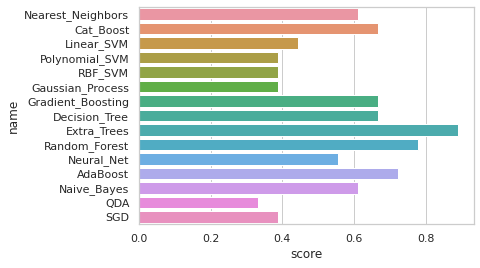

In [102]:
sns.set(style="whitegrid")
ax = sns.barplot(y="name", x="score", data=df)